# Get the LYA$\times$DLA cross-correlation

- ### cross-correlate delta fields of LYA forests and DLA catalog

```
picca_xcf.py --in-dir eboss_lya/ --drq Catalog/DR12_DLA_drq.fits --out Correlations/xcf_dla.fits.gz 
             --rp-max 80 --rp-min -80 --rt-max 60 
             --z-ref 2.3
```

- ### distortion matrix

```
picca_xdmat.py --in-dir eboss_lya/ --drq Catalog/DR12_DLA_drq.fits --out Correlations/xdmat_dla.fits.gz 
               --rp-min -80 --rp-max 80 --rt-max 60 
               --z-ref 2.3 --rej 0.99
```

- ### export the result 

```
picca_export.py --data Correlations/xcf_dla.fits.gz --dmat Correlations/xdmat_dla.fits.gz 
                --out Correlations/e_xcf_dla.fits.gz
```


[ 0.0399516  -0.00724018  0.00349697 ... -0.00142274 -0.00248504
 -0.00408353]


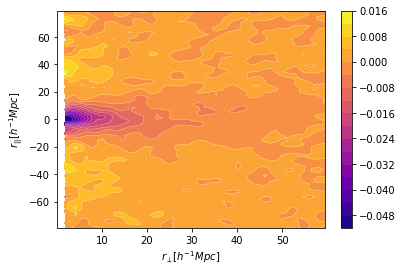

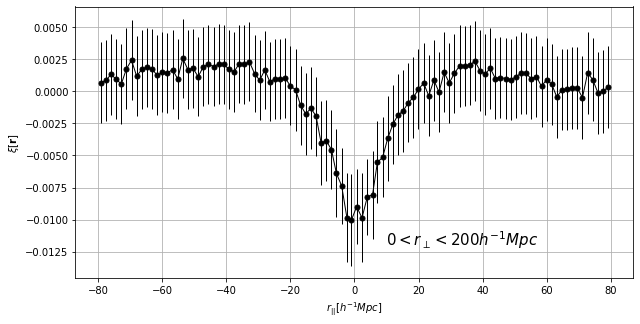

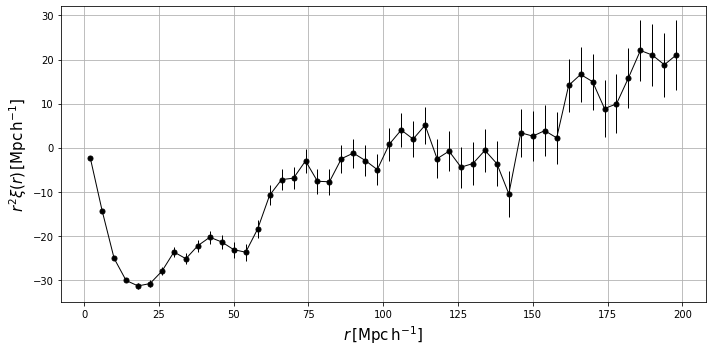

In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import scipy.interpolate
import fitsio
import picca.wedgize

data = fitsio.FITS("Correlations/e_xcf_dla.fits.gz")
rp = data[1]['RP'][:].reshape((100,-1))
rt = data[1]['RT'][:].reshape((100,-1))
da = data[1]['DA'][:]
dda = np.copy(da).reshape((100,-1))
co = data[1]['CO'][:]
print(da)

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
dda[:,0]=np.nan
kernel = Gaussian2DKernel(x_stddev=1)  # smooth the map to improve SNR
conv = convolve(dda,kernel)
conv[:,0] = np.nan
mpl.rcParams['contour.negative_linestyle'] = 'solid'
plt.contour(rt,rp,conv,20,colors=('white',),linewidths=(0.2,),)
plt.contourf(rt,rp,conv,20,cmap='plasma')
plt.xlabel(r'$r_{\perp}[h^{-1}Mpc]$')
plt.ylabel(r'$r_{||}[h^{-1}Mpc]$')
plt.colorbar()
plt.show()

err = np.sqrt(np.diag(co)).reshape((100,-1)).mean(-1)
cor = np.nanmean(dda,axis=1) 
plt.figure(figsize=(10,5))
plt.errorbar(rp.mean(-1),cor,yerr=err,marker='o',c='k',lw=1,ms=5)
plt.grid()
plt.xlabel(r'$r_{||} [h^{-1}Mpc]$')
plt.ylabel(r'$\xi[{\bf r}]$')
plt.text(x=10,y=-0.0120,s=r'$0<r_\perp<200h^{-1}Mpc$',fontsize=15)
plt.show()

w = picca.wedgize.wedge(rpmin=-200.,rpmax=200.,nrp=100,rtmin=0.,rtmax=200.,nrt=50,mumin=-1.,mumax=1.)
w.wedge(da,co)
data_wedge = w.wedge(da,co)
coef = data_wedge[0]**2
plt.figure(figsize=(10,5))
plt.errorbar(data_wedge[0],coef*data_wedge[1],yerr=coef*np.sqrt(np.diag(data_wedge[2])),marker='o',c='k',lw=1,ms=5)
plt.grid()
plt.xlabel(r"$r \, [\mathrm{Mpc \, h^{-1}}]$",fontsize=15)
plt.ylabel(r"$r^2\xi(r) \, [\mathrm{Mpc \, h^{-1}}]$",fontsize=15)
plt.tight_layout()
plt.show()



# Fit of the Data

- ### Fill the 'chi2.ini' file with:

```
[data sets]
zeff = 2.3
ini files = /home/littlelin/Cosmic/lya_xcf/Correlations/Fit/Combined/config_xcf.ini 

[cosmo-fit type]
cosmo fit func = ap_at

[output]
filename = /home/littlelin/Cosmic/lya_xcf/Correlations/Fit/Combined/result.h5

[fiducial]
filename = PlanckDR12/PlanckDR12.fits  

```
 <font color=#228B22> [fiducial]：fiducial cosmology parameters, e.g. Omega_0, Pk_mm</font>

- ### Fill the 'config_xcf.ini' file with:

```
[data]
name = LYA(LYA)xDLA
tracer1 = DLA
tracer2 = LYA
tracer1-type = discrete
tracer2-type = continuous
filename = /home/littlelin/Cosmic/lya_xcf/Correlations/e_xcf_dla.fits.gz
ell-max = 6

[cuts]
rp-min = -80.
rp-max = +80.

rt-min = 0.
rt-max = 60.

r-min = 10.
r-max = 100.

mu-min = 0.
mu-max = +1.

[model]
model-pk = pk_kaiser   
model-xi = xi     
z evol LYA = bias_vs_z_std   
z evol DLA = bias_vs_z_std   
growth function = growth_factor_de  

[parameters]

bias_eta_DLA = 1. 0.3 None None free
beta_DLA = 0.48 0.5 None None free
alpha_DLA = 0. 0. None None fixed
drp_DLA = 0. 0. None None fixed

bias_eta_LYA = 1. 0. None None free
beta_LYA = 1.663 0. None None fixed
alpha_LYA = 2.9 0. None None fixed

bao_amp = 1. 0. None None fixed
ap = 1. 1. 1. 1. fixed
at = 1. 1. 1. 1. fixed

sigmaNL_par = 6.37 0. None None fixed
sigmaNL_per = 3.24 0. None None fixed
growth_rate = 0.968897 0. None None fixed


par binsize LYA(LYA)xDLA = 4 0. None None fixed
per binsize LYA(LYA)xDLA = 4 0. None None fixed
```

<font color=#228B22>bias = growth_rate/beta * bias_eta;\
rp=r\*mu + drp, rt=r\*$\sqrt{1-mu^2}$</font>

 <font color=#228B22>see model-pk in pk.py; \
    see model-xi in xi.py; \
    see bias-evolution-model in xi.py</font>
    
 <font color=#FF0000>Q: growth function = growth_factor_de: to ensure that the input Om and OL comes from the current fiducial cosmology model?</font>
     
 <font color=#FF0000>Q: what's drp? </font>
 
 <font color=#FF0000>Q: Meaning of each parameter</font>
 
 <font color=#FF0000>Q: Why 4 columns? Gaussian-distributed priors: [0]-mu, [1]-sigma, [2]-?, [3]-? </font>
 
- ### run  the fitter

```
picca_fitter2.py chi.ini
```

- ### inspect the results
```
extract_fit_pars.py -i result.h5
```


- ### extract the best-fit model and plot 

```
extract_model.py -i result.h5 -o result.txt

plot_xi.py -d /home/littlelin/Cosmic/lya_xcf/Correlations/e_xcf_dla.fits.gz --mu '0:1' --model result.txt  --abs --rrange '0:100' --out-figure ./result-figure

```

/home/littlelin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


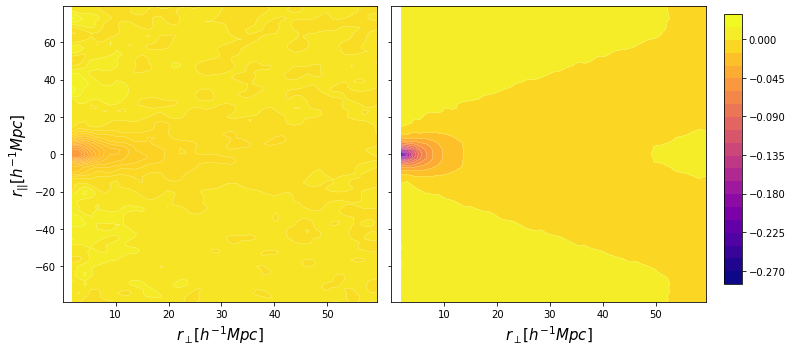

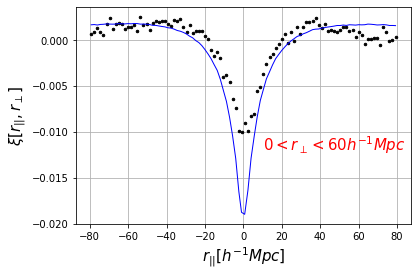

In [11]:
import h5py
r= h5py.File('Correlations/Fit/Combined/result.h5','r')

mcor = r['LYA(LYA)xDLA'][u'fit'][:].reshape((100,-1))

fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(10,5))
mpl.rcParams['contour.negative_linestyle'] = 'solid'
plt.sca(ax2)
mcor[:,0]=np.nan
norm = mpl.colors.Normalize(vmin=np.nanmin(mcor), vmax=np.nanmax(mcor))
plt.contour(rt,rp,mcor[:,:],20,colors=('white',),linewidths=(0.2,),)
plt.contourf(rt,rp,mcor[:,:],20,cmap='plasma',norm=norm)
plt.xlabel(r'$r_{\perp}[h^{-1}Mpc]$',fontsize=15)
l = 1.01
b = 0.2
w = 0.025
h = 0.75
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(cax=cbar_ax)
plt.sca(ax1)
plt.contour(rt,rp,conv[:,:],20,colors=('white',),linewidths=(0.2,),)
plt.contourf(rt,rp,conv[:,:],20,cmap='plasma',norm=norm)
plt.xlabel(r'$r_{\perp}[h^{-1}Mpc]$',fontsize=15)
plt.ylabel(r'$r_{||}[h^{-1}Mpc]$',fontsize=15)
#plt.colorbar()
plt.tight_layout()
plt.show()


mcor = np.nanmean(mcor,axis=1) 
plt.plot(rp.mean(-1),cor,'.',c='k',ms=5)
plt.plot(rp.mean(-1),mcor,c='b',lw=1)
plt.grid()
plt.xlabel(r'$r_{||} [h^{-1}Mpc]$',fontsize=15)
plt.ylabel(r'$\xi[{r_{||},r_{\perp}}]$',fontsize=15)
plt.text(x=10,y=-0.012,s=r'$0<r_\perp<60h^{-1}Mpc$',fontsize=15,color='red')
plt.show()

#r.close()

In [12]:
from scipy.stats import chi2

x=r['best fit'].attrs
for k in ['list of fixed pars','list of free pars'] :
    print("\n"+k)
    print("-------------------------------------------------")
    for i in x[k]:
        try : 
            if k == 'list of free pars' :
                print("%s = %2.4f +/- %2.4f"%(i, x[i][0], x[i][1]))
                param=i.decode("utf-8")
                if param.find("bias_eta")>=0 :
                    what=param.replace("bias_eta_","")
                    beta=x["beta_{}".format(what)][0]
                    growthrate=x["growth_rate"][0]
                    bias=x[i][0]/beta*growthrate
                    bias_err=x[i][1]/beta*growthrate
                    print("bias_%s = %2.4f +/- %2.4f (using f=%2.4f beta=%2.4f)"%(what, bias, bias_err,growthrate, beta))
            else :
                print("%s = %2.4f"%(i, x[i][0]))
                param=i.decode("utf-8")
                if param.find("bias_eta")>=0 :
                    what=param.replace("bias_eta_","")
                    beta=x["beta_{}".format(what)][0]
                    betaerr=x["beta_{}".format(what)][1]
                    growthrate=x["growth_rate"][0]
                    bias=x[i][0]/beta*growthrate
                    bias_err=x[i][0]*betaerr/beta**2*growthrate
                    print("bias_%s = %2.4f +/- %2.4f (using f=%2.4f beta=%2.4f)"%(what, bias, bias_err,growthrate, beta))
        except KeyError:
            continue

fit_attr = ['fval','ndata','npar']
fval  = x['fval']
ndata = x['ndata']
npar  = x['npar']
df = ndata-npar
p = 1 - chi2.cdf(fval,df)

print("\nchi2")
print("-------------------------------------------------")    
print("chi2 = %2.2f, ndata = %i, npar = %i"%(fval,ndata,npar))
print("chi2/DOF = %2.2f/(%i-%i) = %5.3f"%(fval,ndata,npar,fval/(ndata-npar)))
print("p = %2.3f"%(p))

r.close()


list of fixed pars
-------------------------------------------------
b'alpha_DLA' = 0.0000
b'alpha_LYA' = 2.9000
b'ap' = 1.0000
b'at' = 1.0000
b'bao_amp' = 1.0000
b'beta_LYA' = 1.6630
b'drp_DLA' = 0.0000
b'growth_rate' = 0.9689
b'par binsize LYA(LYA)xDLA' = 4.0000
b'per binsize LYA(LYA)xDLA' = 4.0000
b'sigmaNL_par' = 6.3700
b'sigmaNL_per' = 3.2400

list of free pars
-------------------------------------------------
b'beta_DLA' = -0.7558 +/- 0.0253
b'bias_eta_DLA' = 1.1927 +/- 0.5400
bias_DLA = -1.5290 +/- -0.6922 (using f=0.9689 beta=-0.7558)
b'bias_eta_LYA' = 0.7899 +/- 0.3576
bias_LYA = 0.4602 +/- 0.2084 (using f=0.9689 beta=1.6630)

chi2
-------------------------------------------------
chi2 = 6348.29, ndata = 2459, npar = 3
chi2/DOF = 6348.29/(2459-3) = 2.585
p = 0.000
